In [1]:
% matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from data import load_jsonl

In [3]:
train = load_jsonl('train.jsonl')

In [4]:
from collections import Counter
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, f_regression

IGNORE = {
    'a23_pdistress',
    'a33_pdistress',
    'a42_pdistress',
    'essay',
    'id',
    'a11_bsag_total',
    'a11_bsag_anxiety',
    'a11_bsag_depression',
}


def dis_r(truth, predictions, key_reliab=0.77, pred_reliab=0.70):
    return pearsonr(truth, predictions)[0] / np.sqrt(key_reliab * pred_reliab)


dis_r_score = make_scorer(dis_r, greater_is_better=True)


def make_xy(data, label_name, include=None, exclude=IGNORE):
    X, y = [], []
    for i in data:
        label = i[label_name]
        if label == '':
            continue
        d = {}
        for k, v in i.items():
            if include and k not in include:
                continue
            elif exclude and k in exclude:
                continue
            else:
                d[k] = v
        X.append(d)
        y.append(label)
    return X, y


def todense(X):
    return X.todense()


def experiment(data, 
               label_name, 
               feature_names,
               exclude=IGNORE,
               params=None,
               n_jobs=4):
    print(f'Experiment\t{feature_names}\t{label_name}')
    X, y = make_xy(data, label_name,
                   include=feature_names,
                   exclude=exclude)
    
    params = params or {}
    pipeline = make_pipeline(
            DictVectorizer(sparse=False),
            StandardScaler(),
            SGDRegressor(max_iter=1000, 
                         tol=1e3, 
                         penalty='elasticnet', 
                         alpha=0.1),
    )
    grid = GridSearchCV(
        pipeline,
        param_grid=params,
        scoring={
            'dis_r': dis_r_score,
        },
        refit='dis_r',
        n_jobs=n_jobs,
        verbose=0,
        cv=10,
    )
    clf = grid.fit(X, y)
    results = {}
    m = clf.cv_results_['mean_test_dis_r'][clf.best_index_]
    s = clf.cv_results_['std_test_dis_r'][clf.best_index_]
    results['mean_cv_dis_r'] = m
    results['std_cv_dis_r'] = s

    print(f'Results\n{m:.3f}±{2*s:.3f}\t{clf.best_params_}')

    print('\nRanked coefficients:')
    features = clf.best_estimator_.steps[0][1].get_feature_names()
    weights = clf.best_estimator_.steps[-1][1].coef_
    mask = [True for f in features]
    weighted = []  # The list of your K best features
    for selected, feature_name in zip(mask, features):
        if selected:
            weighted.append((feature_name, weights[len(weighted)]))
    for k, v in sorted(weighted, key=lambda i: i[1], reverse=True):
        if not v:
            continue
        print(f'\t{v:.3f}\t{k}')
    return clf, results

all_results = [
    {
        "label": 'Official',
        "a23_pdistress-mean_cv_dis_r": 0.326, "a23_pdistress-std_cv_dis_r": 0,
        "a33_pdistress-mean_cv_dis_r": 0.227, "a33_pdistress-std_cv_dis_r": 0,
        "a42_pdistress-mean_cv_dis_r": 0.196, "a42_pdistress-std_cv_dis_r": 0,
    }
]

## Baseline approaches

Simple regression over the control variables: gender, social class and n_tokens.

In [5]:
params = {
    'sgdregressor__alpha': [0.01, 0.1, 1],
    'sgdregressor__l1_ratio': [0.1, 0.15, 0.2],
    'sgdregressor__max_iter': [500, 1000, 2000],
}

label = 'baseline'
outs = ['a23_pdistress', 'a33_pdistress', 'a42_pdistress']
baseline = {'label': label}
for out in outs:
    clf, results = experiment(
        train, out, 
        ['cntrl_gender', 'cntrl_a11_social_class', 'n_tokens'],
        params=params,             
    )
    baseline.update({f'{out}-{metric}': v for metric, v in results.items()})
    joblib.dump(clf, f'{label}-{out}.pkl')
all_results.append(baseline)

Experiment	['cntrl_gender', 'cntrl_a11_social_class', 'n_tokens']	a23_pdistress
Results
0.376±0.055	{'sgdregressor__alpha': 0.01, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.385	cntrl_gender
	0.091	cntrl_a11_social_class=Unskilled
	0.072	cntrl_a11_social_class=Partly skilled
	0.032	cntrl_a11_social_class=Skilled manual
	-0.029	cntrl_a11_social_class=Skilled non-manual
	-0.062	cntrl_a11_social_class=Professional
	-0.122	cntrl_a11_social_class=Managerial
Experiment	['cntrl_gender', 'cntrl_a11_social_class', 'n_tokens']	a33_pdistress


/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Results
0.251±0.064	{'sgdregressor__alpha': 0.01, 'sgdregressor__l1_ratio': 0.15, 'sgdregressor__max_iter': 500}

Ranked coefficients:
	0.262	cntrl_gender
	0.095	cntrl_a11_social_class=Unskilled
	0.060	cntrl_a11_social_class=Skilled manual
	0.038	cntrl_a11_social_class=Partly skilled
	-0.067	cntrl_a11_social_class=Managerial
	-0.077	cntrl_a11_social_class=Skilled non-manual
	-0.095	cntrl_a11_social_class=Professional
Experiment	['cntrl_gender', 'cntrl_a11_social_class', 'n_tokens']	a42_pdistress
Results
0.239±0.116	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.1, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.292	cntrl_gender
	0.089	cntrl_a11_social_class=Unskilled
	0.008	cntrl_a11_social_class=Skilled manual
	-0.013	cntrl_a11_social_class=Professional
	-0.040	cntrl_a11_social_class=Skilled non-manual
	-0.073	cntrl_a11_social_class=Managerial


## Kitchen sink

In [8]:
outs = ['a23_pdistress', 'a33_pdistress', 'a42_pdistress']
label = 'SGDR-all'
elastic = {'label': label}
exclude = IGNORE.union({f'emb_{i}' for i in range(100)})
for out in outs:
    clf, results = experiment(train, out, 
                     None,
                     exclude=exclude,
                     params=params,
                     n_jobs=4)
    elastic.update({f'{out}-{metric}': v for metric, v in results.items()})
    joblib.dump(clf, f'{label}-{out}.pkl')
all_results.append(elastic)

Experiment	None	a23_pdistress
Results
0.401±0.076	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.394	cntrl_gender
	0.094	read_sentence-beginnings_conjunction
	0.088	EXPERT_zero_sport
	0.075	noise_p_replacement_tokens
	0.054	LIWC_p_LIWC_Certain
	0.049	syn_p_pos-CCONJ
	0.049	stat_mean_sentence
	0.037	EXPERT_p_wealth
	0.022	EXPERT_p_interpersonal-second
	0.021	EXPERT_p_interpersonal-first
	0.019	read_sentence-info_words_per_sentence
	0.017	syn_p_pos-PRON
	0.016	EXPERT_zero_occupation-study
	0.002	cntrl_a11_social_class=Partly skilled
	0.001	EXPERT_zero_timeframe
	0.001	read_readability-grades_Kincaid
	-0.003	cntrl_a11_social_class=Skilled non-manual
	-0.010	read_readability-grades_Coleman-Liau
	-0.010	syn_p_pos-DET
	-0.012	read_word-usage_nominalization
	-0.031	stat_n_types
	-0.033	read_sentence-info_wordtypes
	-0.038	cntrl_a11_social_class=Professional
	-0.041	EXPERT_p_travel
	-0.054	cntrl_a11_social_class=Managerial
	

In [9]:
df = pd.DataFrame(all_results, columns=['label', 
                                     'a23_pdistress-mean_cv_dis_r',
                                     'a23_pdistress-std_cv_dis_r',
                                     'a33_pdistress-mean_cv_dis_r',
                                     'a33_pdistress-std_cv_dis_r',
                                     'a42_pdistress-mean_cv_dis_r',
                                     'a42_pdistress-std_cv_dis_r',
                                     ])
df['a23_pdistress-95CI_dis_r'] = 2 * df['a23_pdistress-std_cv_dis_r']
df['a33_pdistress-95CI_dis_r'] = 2 * df['a23_pdistress-std_cv_dis_r']
df['a42_pdistress-95CI_dis_r'] = 2 * df['a42_pdistress-std_cv_dis_r']

In [10]:
df

,label,a23_pdistress-mean_cv_dis_r,a23_pdistress-std_cv_dis_r,a33_pdistress-mean_cv_dis_r,a33_pdistress-std_cv_dis_r,a42_pdistress-mean_cv_dis_r,a42_pdistress-std_cv_dis_r,a23_pdistress-95CI_dis_r,a33_pdistress-95CI_dis_r,a42_pdistress-95CI_dis_r
0,Official,0.326000,0.000000,0.227000,0.000000,0.196000,0.000000,0.000000,0.000000,0.000000
1,baseline,0.376170,0.027582,0.251216,0.031839,0.238885,0.057943,0.055163,0.055163,0.115885
2,SGDR-all,0.400708,0.038046,0.267534,0.033481,0.233200,0.063754,0.076093,0.076093,0.127508


/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


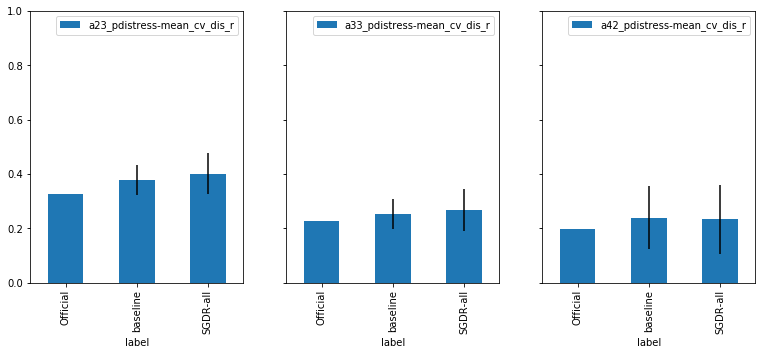

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(13, 5))

df.plot.bar(x='label', y=['a23_pdistress-mean_cv_dis_r'], 
            ax=axes[0], yerr='a23_pdistress-95CI_dis_r',
            ylim=(0, 1))
df.plot.bar(x='label', y=['a33_pdistress-mean_cv_dis_r'], 
            ax=axes[1], yerr='a33_pdistress-95CI_dis_r',
            ylim=(0, 1))
df.plot.bar(x='label', y=['a42_pdistress-mean_cv_dis_r'], 
            ax=axes[2], yerr='a42_pdistress-95CI_dis_r',
            ylim=(0, 1))